# Structure Homology - foldseek

## Summary

"foldseek offers a compelling perspective on the search of far homology: looking on structure space rather than in sequence space. In this notebooks, we analyze the results that we have obtanined manually for different queries.


In [1]:
import pandas as pd
import numpy as np
import requests, sys
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import requests, sys
import plotly.express as px

I'm writing first a generator to iterate over the different files, and a loop fed by that generator to concatenate pandas dataframes all togehter. After that, I'll add taxonomic annotation through the ENSMBLE REST API.

We will consider that a hit is anything with an evalue lower than 0.01. The criteria to decide what's a lead is still on the air.

In [2]:
def read_m8_file_3daa(filename):
    """
    Parses the m8 files genrated with foldseek aa-3d method

    """

    foldseek_matches = pd.read_csv(
        filename, sep='\t', header=None, index_col=None,
        names=["_", "target","fident","alnlen","mismatch","gapopen","qstart","qend","tstart","tend", "probability",
            "evalue","bits", "u1", "u2", "u3", "u4", "u5", "sequence", "taxonID", "organism"]
    )

    foldseek_matches = foldseek_matches[['target', 'fident', 'alnlen', 'mismatch', 'evalue', 'bits', 'organism', 'sequence', 'taxonID']]
    foldseek_matches['logevalue'] = foldseek_matches['evalue'].apply(np.log10)


    return foldseek_matches


def read_m8_file_tmalign(filename):
    foldseek_matches = pd.read_csv(
        filename, sep='\t', header=None, index_col=None,
        names=["_", "target","fident","alnlen","mismatch","gapopen","qstart","qend","tstart","tend", "probability",
            "tm_score","bits", "u1", "u2", "u3", "u4", "u5", "sequence", "taxonID", "organism"]
    )

    foldseek_matches = foldseek_matches[['target', 'fident', 'alnlen', 'mismatch', 'tm_score', 'bits', 'organism', 'sequence', 'taxonID']]

    return foldseek_matches

def get_taxa_information(taxon_id):
    """
    Downloads a dictionary with all the taxonomic information. Check

    https://rest.ensembl.org/documentation/info/taxonomy_classification

    to know more

    """
    server = "https://rest.ensembl.org"
    ext = f"/taxonomy/classification/{taxon_id}?"
    
    r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
    
    if not r.ok:
        return None
    
    decoded = r.json()
    return decoded

def write_fasta(id, sequence):
    return f"> {id}\n{sequence}\n"
    
    

In [3]:
def examine_folders_3daa():
    alignment_files = glob.glob('../data/foldseek/*.3di.m8')
    print(alignment_files)
    for file in alignment_files:
        yield file

def examine_folders_tmalign():
    alignment_files = glob.glob('../data/foldseek/*.tmalign.m8')
    for file in alignment_files:
        yield file

In [4]:
foldseek_results_3daa = []
for file in examine_folders_3daa():
    tmp = read_m8_file_3daa(file)
    tmp['query'] = file.split('/')[-1].replace('alis_', '').replace('.m8', '').replace('_afdb-','').replace('.3di', '')
    foldseek_results_3daa.append(tmp)

foldseek_results_3daa = pd.concat(foldseek_results_3daa)
foldseek_results_3daa.replace(np.nan, None, inplace=True)
foldseek_results_3daa.reset_index(level=0, inplace=True)
foldseek_results_3daa['len_sequence'] = foldseek_results_3daa['sequence'].apply(len)
foldseek_results_3daa['target'] = foldseek_results_3daa['target'].apply(lambda x: x.split()[0])
foldseek_results_3daa['target'] = foldseek_results_3daa['target'].str.replace('.pdb.gz', '', regex=True).str.replace('-F1-model_v4', '', regex=True)
foldseek_results_3daa[:10]

['../data/foldseek/alis_pdb100.3di.m8', '../data/foldseek/alis_uniprot.3di.m8', '../data/foldseek/alis_gmgcl_id.3di.m8', '../data/foldseek/alis_afdb-proteome.3di.m8', '../data/foldseek/alis_swissprot.3di.m8']


,index,target,fident,alnlen,mismatch,evalue,bits,organism,sequence,taxonID,logevalue,query,len_sequence
0,0,7aiz_C,100.0,112,0,3.274000e-16,782,Azotobacter vinelandii,SQSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQE...,354.0,-15.484921,pdb100,112
1,1,7ady_C,100.0,111,0,3.451000e-16,780,Azotobacter vinelandii,MSQSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQ...,354.0,-15.462055,pdb100,113
2,2,5n6y_F,100.0,110,0,5.547000e-16,763,Azotobacter vinelandii,QSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQEP...,354.0,-15.255942,pdb100,111
3,3,2qe9_B,9.6,135,93,6.098000e-01,45,Bacillus subtilis subsp. subtilis str. 168,HHHHENLYFQGKFFEYNWQVRDQWFTWCHQLTTEELLKNRLGGVEN...,224308.0,-0.214813,pdb100,160
4,4,7vws_B,16.1,93,63,2.668000e+00,37,unclassified,TIVQELDQAGITDSGLRADYITVSRLFREIGRGRYLGRYMFPAAKR...,0.0,0.426186,pdb100,328
5,5,5fhx_A,13.3,120,86,2.050000e+00,35,Homo sapiens,TLQEIIKTLNSLTEQKTLCTELTVTDIFAANTTEKETFCRAATVLR...,9606.0,0.311754,pdb100,122
6,6,7mir_A,9.8,122,80,2.278000e+00,34,Legionella pneumophila subsp. pneumophila str....,VKQYYFARRGETSTHDTSLPPPVKVLSGRSIPLKEIPFEATRNELV...,272624.0,0.357554,pdb100,750
7,7,7vwt_A,17.2,93,60,5.294000e+00,32,unclassified,GPSTVQELDLAGITDSGLRADYIASSQLFRKIGRGRFLGRYMMHPA...,0.0,0.723784,pdb100,326
8,8,7ppo_C,9.2,119,84,4.765000e+00,30,Legionella pneumophila subsp. pneumophila str....,KQYYFARRGETSTHDTSLPPPVKVLSGRSIPLKEIPFETTRNELVQ...,272624.0,0.678063,pdb100,749
9,9,1hzi_A,12.9,124,84,3.661000e+00,29,Homo sapiens,HKCDITLQAIIKTLNSLTEQKTLCTELTVTDIFAASKNTTEKETFC...,9606.0,0.563600,pdb100,129


In [5]:
foldseek_results_3daa['query'].unique()

array(['pdb100', 'uniprot', 'gmgcl_id', 'swissprot'], dtype=object)

In [6]:
foldseek_results_tmalign = []
for file in examine_folders_tmalign():

    tmp = read_m8_file_tmalign(file)
    tmp['db'] = file.split('/')[-1].replace('alis_', '').replace('.m8', '').replace('.tmalign', '')

    foldseek_results_tmalign.append(tmp)

foldseek_results_tmalign = pd.concat(foldseek_results_tmalign)
foldseek_results_tmalign.reset_index(level=0, inplace=True)
foldseek_results_tmalign['len_sequence'] = foldseek_results_tmalign['sequence'].apply(len)
foldseek_results_tmalign['target'] = foldseek_results_tmalign['target'].apply(lambda x: x.split()[0])
foldseek_results_tmalign['target'] = foldseek_results_tmalign['target'].str.replace('.pdb.gz', '', regex=True).str.replace('-F1-model_v4', '', regex=True)
foldseek_results_tmalign[:10]


,index,target,fident,alnlen,mismatch,tm_score,bits,organism,sequence,taxonID,db,len_sequence
0,0,AF-X8F8E9,5.3,113,75,0.3775,39,Mycobacterium ulcerans str. Harvey,MDKLVAGVQQALRTTTDNRGRLYAAVQAFFDFIEHDSQGYRLIFEN...,1299332.0,afdb-proteome,134
1,1,AF-G3V6X6,4.6,151,69,0.3486,41,Rattus norvegicus,MSVLRKSMSFSLMGTLAASCLLLVALWAQKADALPINSQCKLEAAN...,10116.0,afdb-proteome,179
2,2,AF-X8F9D9,1.8,111,55,0.3485,33,Mycobacterium ulcerans str. Harvey,MSFVTTQPEALAAAAANLQGIGTTMSAQNAAAAAPTTGVVPAAADE...,1299332.0,afdb-proteome,99
3,3,AF-Q9JJY9,6.2,143,68,0.3432,39,Mus musculus,MAVLQKSMSFSLMGTLAASCLLLIALWAQEANALPVNTRCKLEVSN...,10090.0,afdb-proteome,179
4,4,AF-Q49724,1.7,114,53,0.3392,32,Mycobacterium leprae TN,MSFFLRVEVGGLMMAAGRLERITSESMACNAKLTPVTTKVVPPAAD...,272631.0,afdb-proteome,100
5,5,AF-I6YGS7,0.8,119,55,0.3390,32,Mycobacterium tuberculosis H37Rv,MSIMHAEPEMLAATAGELQSINAVARAGNAAVAGPTTGVVPAAADL...,83332.0,afdb-proteome,99
6,6,AF-Q79FR5,3.3,119,49,0.3329,31,Mycobacterium tuberculosis H37Rv,MSFVTTRPDSIGETAANLHEIGVTMSAHDDGVTPLITNVESPAHDL...,83332.0,afdb-proteome,100
7,7,AF-Q6J2R6,4.5,155,89,0.3306,49,Danio rerio,MFAKATKNLLSEIDSEGFLIPVLCLNDSDGLSPQALVIKRNRYWFW...,7955.0,afdb-proteome,472
8,8,AF-K0F6D7,4.2,117,72,0.3274,40,Nocardia brasiliensis ATCC 700358,MTDLVDRMTSRRTSSEPAKRGTRLPRDERRLQLLAAASEVFVQRGY...,1133849.0,afdb-proteome,218
9,9,AF-X8FFL1,2.7,110,55,0.3143,33,Mycobacterium ulcerans str. Harvey,MSFLIAAPDMVAAAATDLASIGSTINTANAAASALTTSVAAAAADE...,1299332.0,afdb-proteome,135


In [7]:
foldseek_results_tmalign['db'].unique()

array(['afdb-proteome', 'gmgcl_id', 'pdb100', 'swissprot', 'uniprot'],
      dtype=object)

In [8]:
foldseek_results_tmalign['db'].unique()

array(['afdb-proteome', 'gmgcl_id', 'pdb100', 'swissprot', 'uniprot'],
      dtype=object)

In [9]:
foldseek_results = pd.merge(
    foldseek_results_3daa[['target', 'alnlen', 'mismatch', 'logevalue', 'evalue', 'organism', 'sequence', 'len_sequence', 'query', 'taxonID']], 
    foldseek_results_tmalign[['target', 'alnlen', 'mismatch', 'tm_score', 'organism', 'sequence', 'len_sequence', 'db', 'taxonID']], 
    how='outer',
    on='target'
)


In [10]:
foldseek_results.drop_duplicates(subset='target')

,target,alnlen_x,mismatch_x,logevalue,evalue,organism_x,sequence_x,len_sequence_x,query,taxonID_x,alnlen_y,mismatch_y,tm_score,organism_y,sequence_y,len_sequence_y,db,taxonID_y
0,7aiz_C,112,0,-15.484921,3.274000e-16,Azotobacter vinelandii,SQSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQE...,112.0,pdb100,354.0,112.0,0.0,0.9986,Azotobacter vinelandii,SQSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQE...,112.0,pdb100,354.0
1,7ady_C,111,0,-15.462055,3.451000e-16,Azotobacter vinelandii,MSQSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQ...,113.0,pdb100,354.0,112.0,0.0,0.9948,Azotobacter vinelandii,MSQSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQ...,113.0,pdb100,354.0
2,5n6y_F,110,0,-15.255942,5.547000e-16,Azotobacter vinelandii,QSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQEP...,111.0,pdb100,354.0,111.0,0.0,0.9901,Azotobacter vinelandii,QSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQEP...,111.0,pdb100,354.0
3,2qe9_B,135,93,-0.214813,6.098000e-01,Bacillus subtilis subsp. subtilis str. 168,HHHHENLYFQGKFFEYNWQVRDQWFTWCHQLTTEELLKNRLGGVEN...,160.0,pdb100,224308.0,127.0,66.0,0.3513,Bacillus subtilis subsp. subtilis str. 168,HHHHENLYFQGKFFEYNWQVRDQWFTWCHQLTTEELLKNRLGGVEN...,160.0,pdb100,224308.0
4,7vws_B,93,63,0.426186,2.668000e+00,unclassified,TIVQELDQAGITDSGLRADYITVSRLFREIGRGRYLGRYMFPAAKR...,328.0,pdb100,0.0,161.0,78.0,0.3784,unclassified,TIVQELDQAGITDSGLRADYITVSRLFREIGRGRYLGRYMFPAAKR...,328.0,pdb100,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,AF-A0A662P7C5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,53.0,0.2118,Thermococci archaeon,MAFEPGGMSEKLGNRYEGRWVARQLLRLLNEEIESVTVELIGPDER...,403.0,uniprot,2250254.0
453,AF-A0A1K1PSU6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.0,51.0,0.2047,Ruminococcus sp. YE71,MLYTTSINCTTNAEQAYTQMRLVYEQFARDKFSSPKPLEGKGSVKA...,447.0,uniprot,244362.0
454,AF-A0A534XKL3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0,56.0,0.1999,Deltaproteobacteria bacterium,YNRGGLAFDPWRYFEQPYGPSDVIAADLFGEGRHDLVVPNWRDNHL...,539.0,uniprot,2026735.0
455,AF-I4BAM9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,367.0,69.0,0.1992,Turneriella parva DSM 21527,MIFYLKPMQNLPEVFAASAQKYPDQGFYSKDSHKFFMPTRFSVLYE...,634.0,uniprot,869212.0


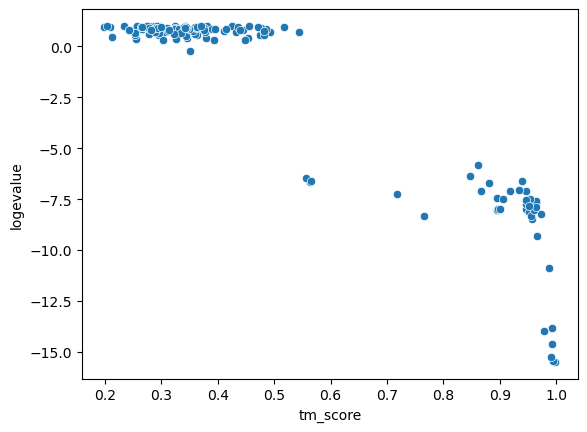

In [11]:
fig, ax = plt.subplots(1)
sns.scatterplot(
    x='tm_score', y='logevalue', data=foldseek_results
)


plt.savefig('../figures/all_matches.svg')

In [12]:
foldseek_results[~ pd.isna(foldseek_results['tm_score'])]

,target,alnlen_x,mismatch_x,logevalue,evalue,organism_x,sequence_x,len_sequence_x,query,taxonID_x,alnlen_y,mismatch_y,tm_score,organism_y,sequence_y,len_sequence_y,db,taxonID_y
0,7aiz_C,112,0,-15.484921,3.274000e-16,Azotobacter vinelandii,SQSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQE...,112.0,pdb100,354.0,112.0,0.0,0.9986,Azotobacter vinelandii,SQSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQE...,112.0,pdb100,354.0
1,7ady_C,111,0,-15.462055,3.451000e-16,Azotobacter vinelandii,MSQSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQ...,113.0,pdb100,354.0,112.0,0.0,0.9948,Azotobacter vinelandii,MSQSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQ...,113.0,pdb100,354.0
2,5n6y_F,110,0,-15.255942,5.547000e-16,Azotobacter vinelandii,QSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQEP...,111.0,pdb100,354.0,111.0,0.0,0.9901,Azotobacter vinelandii,QSHLDDLFAYVEERCLWQFFSRTWDREENIEGVLNQVGRLLTGQEP...,111.0,pdb100,354.0
3,2qe9_B,135,93,-0.214813,6.098000e-01,Bacillus subtilis subsp. subtilis str. 168,HHHHENLYFQGKFFEYNWQVRDQWFTWCHQLTTEELLKNRLGGVEN...,160.0,pdb100,224308.0,127.0,66.0,0.3513,Bacillus subtilis subsp. subtilis str. 168,HHHHENLYFQGKFFEYNWQVRDQWFTWCHQLTTEELLKNRLGGVEN...,160.0,pdb100,224308.0
4,7vws_B,93,63,0.426186,2.668000e+00,unclassified,TIVQELDQAGITDSGLRADYITVSRLFREIGRGRYLGRYMFPAAKR...,328.0,pdb100,0.0,161.0,78.0,0.3784,unclassified,TIVQELDQAGITDSGLRADYITVSRLFREIGRGRYLGRYMFPAAKR...,328.0,pdb100,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,AF-A0A662P7C5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,53.0,0.2118,Thermococci archaeon,MAFEPGGMSEKLGNRYEGRWVARQLLRLLNEEIESVTVELIGPDER...,403.0,uniprot,2250254.0
453,AF-A0A1K1PSU6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.0,51.0,0.2047,Ruminococcus sp. YE71,MLYTTSINCTTNAEQAYTQMRLVYEQFARDKFSSPKPLEGKGSVKA...,447.0,uniprot,244362.0
454,AF-A0A534XKL3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0,56.0,0.1999,Deltaproteobacteria bacterium,YNRGGLAFDPWRYFEQPYGPSDVIAADLFGEGRHDLVVPNWRDNHL...,539.0,uniprot,2026735.0
455,AF-I4BAM9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,367.0,69.0,0.1992,Turneriella parva DSM 21527,MIFYLKPMQNLPEVFAASAQKYPDQGFYSKDSHKFFMPTRFSVLYE...,634.0,uniprot,869212.0


In [13]:
foldseek_results[pd.isna(foldseek_results['evalue'])].query('tm_score > 0.5')

,target,alnlen_x,mismatch_x,logevalue,evalue,organism_x,sequence_x,len_sequence_x,query,taxonID_x,alnlen_y,mismatch_y,tm_score,organism_y,sequence_y,len_sequence_y,db,taxonID_y


In [14]:
hits = foldseek_results.query(
    'tm_score > 0.5 or logevalue < -2'
)
hits = hits.drop_duplicates('target', keep='first')
print(len(hits))

42


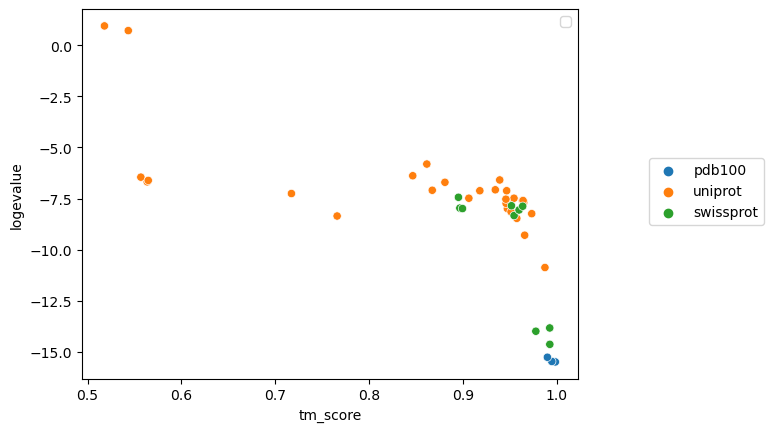

In [15]:
fig, ax = plt.subplots(1)
sns.scatterplot(
    x='tm_score', y='logevalue', hue='db', data=hits,  legend=True
)
ax.legend('')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [16]:
hits[hits['tm_score'].isna()]

,target,alnlen_x,mismatch_x,logevalue,evalue,organism_x,sequence_x,len_sequence_x,query,taxonID_x,alnlen_y,mismatch_y,tm_score,organism_y,sequence_y,len_sequence_y,db,taxonID_y


In [17]:
hits[hits['logevalue'].isna()]

,target,alnlen_x,mismatch_x,logevalue,evalue,organism_x,sequence_x,len_sequence_x,query,taxonID_x,alnlen_y,mismatch_y,tm_score,organism_y,sequence_y,len_sequence_y,db,taxonID_y


In [18]:
hits = hits[['target', 'tm_score', 'logevalue', 'organism_x', 'sequence_x', 'len_sequence_x', 'query', 'db', 'taxonID_x']]
hits = hits.rename(columns={'organism_x':'organism', 'sequence_x':"sequence", 'len_sequence_x':"len_sequence","taxonID_x":"taxon_id"})

hits['taxon_id'] = hits['taxon_id'].astype('Int64')
hits['taxa_information'] = hits['taxon_id'].apply(lambda x : get_taxa_information(x))

In [19]:
def extract_parent(x):
    """
    just a taylored function to get a good group notation from
    ENSMBLE taxonomy. In E. coli, it should provide `proteobacteria`
    """

    if x is None:
        return "unknown"
    else:
        try:
            return x[-2]['name']
        except:
            return x[-1]['name']

hits['taxa_group'] = hits['taxa_information'].apply(extract_parent)


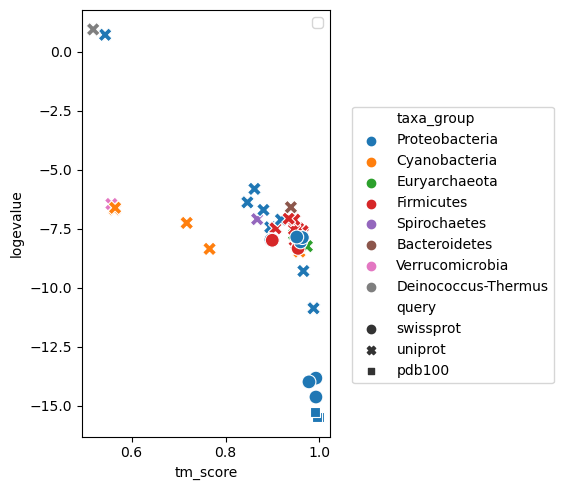

In [20]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3.5, 5)
sns.scatterplot(
    x='tm_score', y='logevalue', hue='taxa_group', data=hits,
    s=100, style='query', style_order=['swissprot', 'uniprot', 'pdb100']
)
ax.legend('')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig('../figures/foldseek_hits.svg')

**Results**: Number of hits for each of the databases, using our E-score cutoff.

In [21]:
hits.groupby('query').count()['target']

query
pdb100        3
swissprot     9
uniprot      30
Name: target, dtype: int64

Species showing up in UniProt and SwissProt

We note that it's very likely that the criteria to assign Evalues is failing in the case of GMGCL, given that they are far above 1.

In [22]:
hits[['target', 'logevalue', 'tm_score', 'taxa_group', 'taxon_id']].to_csv(
    '../data/foldseek/foldseek.hits.csv'
)
hits[['target', 'logevalue', 'tm_score', 'taxa_group', 'taxon_id']]

,target,logevalue,tm_score,taxa_group,taxon_id
0,7aiz_C,-15.484921,0.9986,Proteobacteria,354
1,7ady_C,-15.462055,0.9948,Proteobacteria,354
2,5n6y_F,-15.255942,0.9901,Proteobacteria,354
25,AF-A0A431LH34,-10.868702,0.9875,Proteobacteria,1898103
26,AF-A0A7W6QT66,-9.288868,0.9659,Proteobacteria,1074
27,AF-A0A841WJR6,-8.464706,0.9575,Cyanobacteria,2485484
28,AF-A0A6N0M253,-8.350276,0.7660,Cyanobacteria,2572090
29,AF-A0A0E3R0D7,-8.235749,0.9734,Euryarchaeota,1434106
30,AF-A0A810E0W3,-7.983803,0.9474,Firmicutes,2741301
31,AF-E6U4U0,-8.144178,0.9514,Firmicutes,663278
